In [2]:
import numpy as np
from scipy.spatial.distance import euclidean
import random


In [14]:
# class Kmeans:
#     def __init__(self, k, max_iter=100):
#         super().__init__(k, max_iter)
#         self.centroids = None
#         self.clusters = None
#         self.k = k
#         self.max_iter = max_iter
#
#     def fit(self, X):
#         self.centroids = self._init_centroids(X, self.k)
#         for i in range(self.max_iter):
#             self.clusters = self._create_clusters(X)
#             old_centroids = self.centroids
#             self.centroids = self._get_centroids(self.clusters)
#             if self._is_converged(old_centroids, self.centroids):
#                 break
#         return self
#
#     def _init_centroids(self, X, k):
#         centroids = np.zeros((k, X.shape[1]))
#         for i in range(k):
#             centroid = X[np.random.choice(range(len(X)))]
#             centroids[i] = centroid
#         return centroids
#
#     def _create_clusters(self, X):
#         clusters = [[] for _ in range(self.k)]
#         for sample in X:
#             centroid_idx = self._closest_centroid(sample, self.centroids)
#             clusters[centroid_idx].append(sample)
#         return clusters
#
#     def _closest_centroid(self, sample, centroids):
#         distances = [euclidean(sample, point) for point in centroids]
#         closest_idx = np.argmin(distances)
#         return closest_idx
#
#     def _get_centroids(self, clusters):
#         centroids = np.zeros((self.k, clusters[0].shape[1]))
#         for idx, cluster in enumerate(clusters):
#             centroid = np.mean(cluster, axis=0)
#             centroids[idx] = centroid
#         return centroids
#
#     def _is_converged(self, old_centroids, centroids):
#         distances = [euclidean(old_centroids[i], centroids[i]) for i in range(self.k)]
#         return sum(distances) == 0

In [9]:
def calc_avg(Ci, d):
    sum1 = np.zeros((1, d))
    size = len(Ci)

    for x in Ci:
        sum1 += x

    for i in range(d):
        sum1[0][i] = sum1[0][i] / size

    return sum1

def euclidean_distance(point1, point2):
    return np.sqrt(np.sum((np.array(point1) - np.array(point2)) ** 2))

In [21]:
def kmeans(X, k, t = 100):
    """
    :param X: numpy array of size (m, d) containing the test samples
    :param k: the number of clusters
    :param t: the number of iterations to run
    :return: a column vector of length m, where C(i) ∈ {1, . . . , k} is the identity of
    the cluster in which x_i has been assigned.
    """
    m = X.shape[0]
    d = X.shape[1]

    # Initialize cluster centroids randomly
    cluster_centroids = [X[random.randint(0, m - 1)] for _ in range(k)]
    cluster_assignments = [-1 for _ in range(m)]

    for _ in range(t):
        # Assign each point to the closest cluster centroid
        cluster_assignments = []
        for x in X:
            distances = [euclidean_distance(x, centroid) for centroid in cluster_centroids]
            # Choose the centroid that minimize the distance from x - Define Ci
            cluster_assignments.append(np.argmin(distances))

        # Recompute the centroids of the clusters
        new_cluster_centroids = []
        for i in range(k):
            Ci = [X[j] for j in range(m) if cluster_assignments[j] == i]  # Build cluster Ci

            if len(Ci) != 0:  # Cluster is not empty
                avg = calc_avg(Ci, d)
                new_cluster_centroids.append(avg)  # avg of samples in the cluster

            else:  # If a cluster is empty, initialize its centroid randomly
                new_cluster_centroids.append(X[np.random.randint(m - 1)])

        # Check if the clusters have changed
        if np.array_equal(new_cluster_centroids, cluster_centroids):
            break

        else:
            cluster_centroids = new_cluster_centroids

    cluster_assignments = np.asarray(cluster_assignments)
    cluster_assignments = cluster_assignments.reshape((m, 1))

    return cluster_assignments


In [5]:


# def initiate_centroids(x_list: np.array, k: int):
#     indices = np.arange(x_list.shape[0])
#     np.random.shuffle(indices)
#     rearranged_x = x_list[indices]
#     return rearranged_x[:k]
#
#
# def find_closest_centroid(x_i: np.array, centroids: np.array) -> int:
#     # print(f"inf in x_i: {np.isinf(x_i).any()}")
#     # print(f"nan in x_i: {np.isnan(x_i).any()}")
#     # print(f"inf in centroids: {np.isinf(centroids).any()}")
#     # print(f"nan in centroids: {np.isnan(centroids).any()}")
#     distances: np.array = np.array([euclidean(x_i, centroid) for centroid in centroids])
#     try:
#         return np.argmin(distances)[0]
#     except IndexError:
#         return np.argmin(distances)
#
#
# def get_cluster_indices(i: int, clusters_for_examples: np.array):
#     return [index for index, cluster_label in enumerate(clusters_for_examples) if cluster_label == i]
#
#
# def calculate_new_centroid(cluster: np.array):
#     return np.sum(cluster, axis=0) / len(cluster)
#
#
# def calculate_new_centroids(X: np.array, k: int, clusters_for_examples: np.array):
#     return np.array([
#         calculate_new_centroid(
#             X[get_cluster_indices(i, clusters_for_examples)]
#         ) for i in range(k)
#     ])
#
#
# def kmeans(X, k, t):
#     """
#     :param X: numpy array of size (m, d) containing the test samples
#     :param k: the number of clusters
#     :param t: the number of iterations to run
#     :return: a column vector of length m, where C(i) ∈ {1, . . . , k} is the identity of the cluster in which x_i has been assigned.
#     """
#     # Choose k random medians from X
#     centroids: np.array = initiate_centroids(X, k)
#     clusters_for_examples = np.array([])
#     for i in range(t):
#         print(f"iteration: {i + 1}")
#         # Calculate the clusters (for every example find its closest median)
#         clusters_for_examples = np.array([find_closest_centroid(x_i, centroids) for x_i in X])
#         # Calculate new centroids
#         centroids = calculate_new_centroids(X, k, clusters_for_examples)
#         # t iterations or no change in medians
#     clusters_for_examples = clusters_for_examples.reshape((clusters_for_examples.shape[0], 1))
#     print(f"clusters_for_examples shape: {clusters_for_examples.shape}")
#     return clusters_for_examples

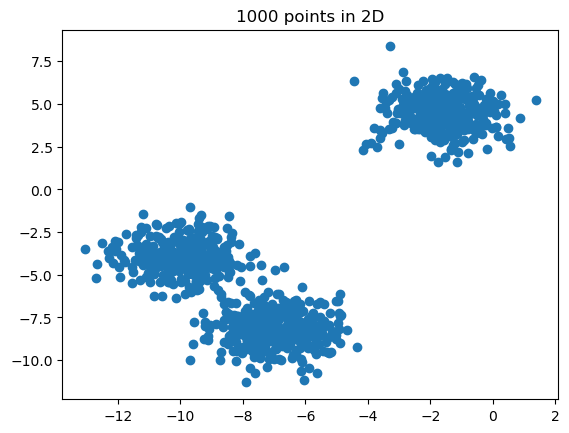

In [44]:
# generate  2D data of N = 1000 points using sklearn
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
X, y = make_blobs(n_samples=1000, centers=3, n_features=2, random_state=1)

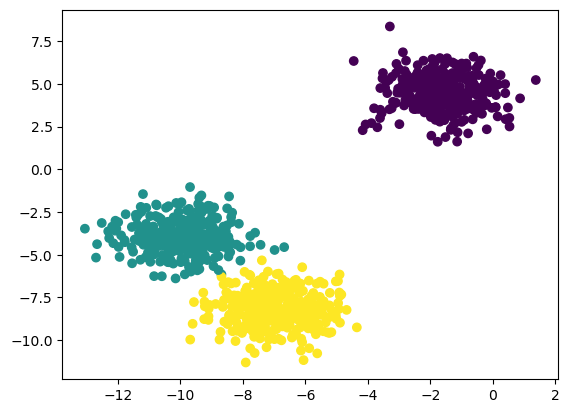

In [15]:
plt.scatter(X[:,0], X[:,1])



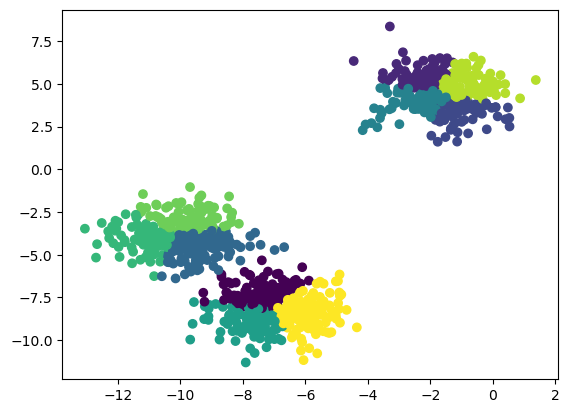

In [16]:
labels = kmeans(X, 3)
plt.scatter(X[:,0], X[:,1], c=labels)

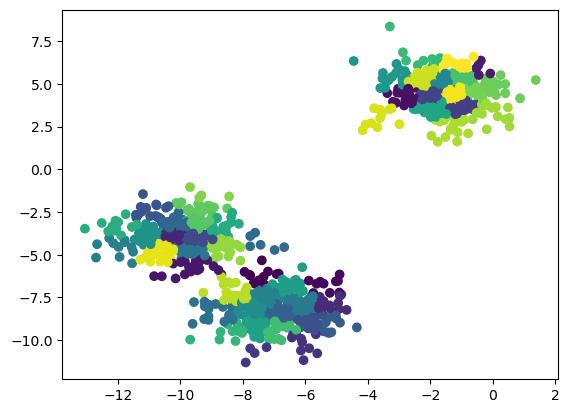

In [17]:
labels = kmeans(X, 10)
plt.scatter(X[:,0], X[:,1], c=labels)

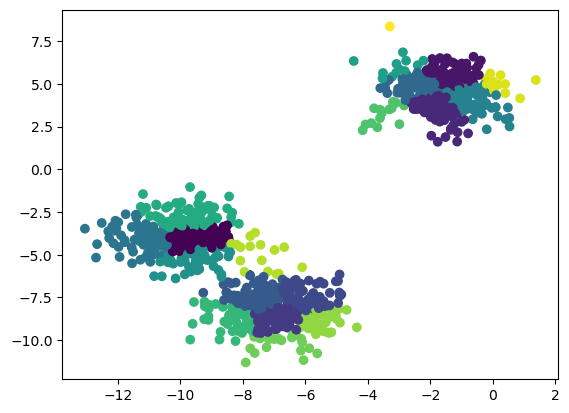

In [33]:
labels = kmeans(X, 50)
plt.scatter(X[:,0], X[:,1], c=labels)

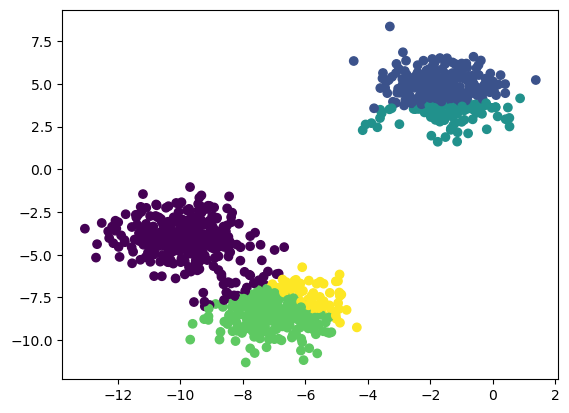

In [34]:
def pdc_dp_means(X, l, t = 100):
    """
    :param X: numpy array of size (m, d) containing the test samples
    :param l: hyperparameter
    :param t: the number of iterations to run
    :return: a column vector of length m, where C(i) ∈ {1, . . . , k} is the identity of
    the cluster in which x_i has been assigned.
    """
    m = X.shape[0]
    d = X.shape[1]
    k = 1

    # Initialize cluster centroids randomly
    cluster_centroids = [calc_avg(X, d)]
    cluster_assignments = [1 for _ in range(m)]

    for _ in range(t):
        # Assign each point to the closest cluster centroid
        cluster_assignments = [np.argmin([euclidean_distance(x, centroid) for centroid in cluster_centroids]) for x in X]
        distances = [euclidean_distance(X[i], cluster_centroids[cluster_assignments[i]]) for i in range(m)]
        j_max = np.argmax(distances)

        try:
            d_max = distances[j_max]
        except IndexError:
            d_max = distances[j_max[0]]

        if d_max > l:
            k += 1
            cluster_centroids.append(X[j_max])
            cluster_assignments[j_max] = k
        else:
            break

        # Recompute the centroids of the clusters
        new_cluster_centroids = []
        for i in range(k):
            Ci = [X[j] for j in range(m) if cluster_assignments[j] == i]  # Build cluster Ci

            if len(Ci) != 0:  # Cluster is not empty
                avg = calc_avg(Ci, d)
                new_cluster_centroids.append(avg)  # avg of samples in the cluster

            else:  # If a cluster is empty, initialize its centroid randomly
                new_cluster_centroids.append(X[np.random.randint(m - 1)])

        # Check if the clusters have changed
        if np.array_equal(new_cluster_centroids, cluster_centroids):
            break

        else:
            cluster_centroids = new_cluster_centroids

    cluster_assignments = np.asarray(cluster_assignments)
    cluster_assignments = cluster_assignments.reshape((m, 1))

    return cluster_assignments


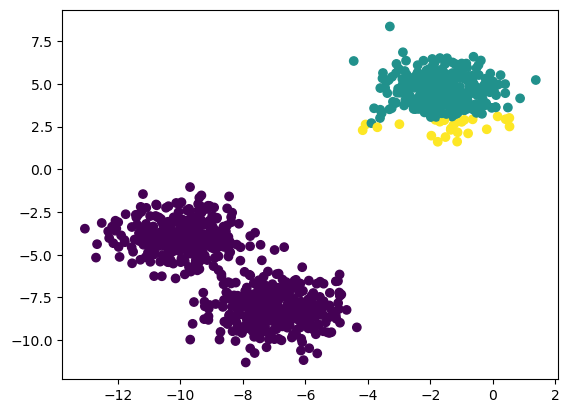

In [35]:
labels = pdc_dp_means(X, 10, 20)
plt.scatter(X[:,0], X[:,1], c=labels)

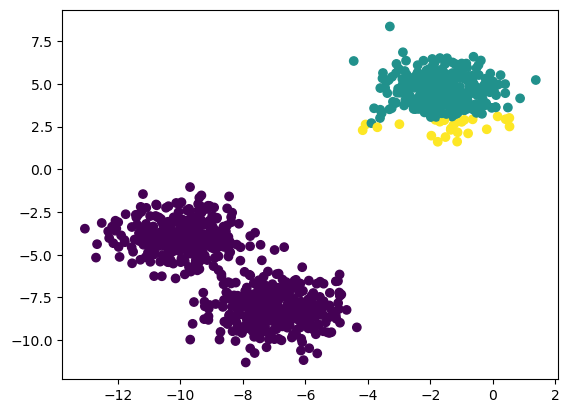

In [39]:
labels = pdc_dp_means(X, 6, 20)
plt.scatter(X[:,0], X[:,1], c=labels)